Voice Activity Detection Model 

Name: P.A. Hasith Vikasitha Dharmarathna
ID: 20223265
Course: 6COSC020W Applied AI 

Part A - Application Area Review

In [1]:
## TODO

Part B - Compare and Evaluate AI Techniques

In [2]:
## TODO

Part C - Implementation


Python Prototype

In [3]:
## Library Imports

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torchaudio
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


In [5]:
## Dataset Download and Preparation

import tarfile
import urllib.request

DATA_URL = "https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.01.tar.gz"
DATA_DIR = "speech_commands_v0.01"
TAR_PATH = "speech_commands_v0.01.tar.gz"

if not os.path.exists(DATA_DIR):
    print("Downloading Speech Commands dataset...")
    urllib.request.urlretrieve(DATA_URL, TAR_PATH)

    print("Extracting dataset...")
    with tarfile.open(TAR_PATH, "r:gz") as tar:
        tar.extractall()

    print("Dataset ready.")
else:
    print("Dataset already exists.")


Dataset already exists.


In [6]:
## Dataset Structure

print(os.listdir(DATA_DIR))

['bird', 'LICENSE', 'stop', 'one', 'two', 'wow', 'bed', 'left', 'no', 'README.md', 'house', 'validation_list.txt', 'on', 'five', 'down', 'tree', 'dog', 'four', 'eight', 'seven', 'happy', '_background_noise_', 'sheila', 'marvin', 'three', 'six', 'testing_list.txt', 'go', 'zero', 'up', 'cat', 'nine', 'yes', 'off', 'right']


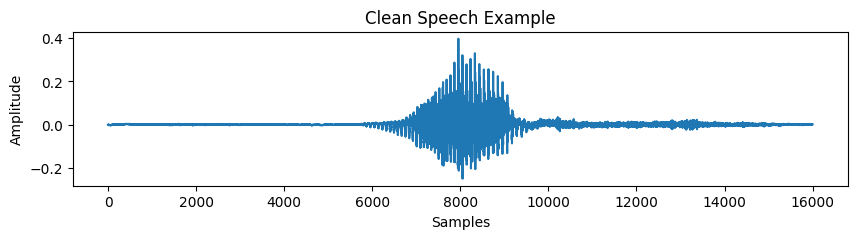

In [7]:
## Load one Clean Speech Sample

sample_path = os.path.join(DATA_DIR, "yes")
sample_file = random.choice(os.listdir(sample_path))

speech, fs = torchaudio.load(os.path.join(sample_path, sample_file))
speech = speech.mean(0)

plt.figure(figsize=(10,2))
plt.plot(speech.numpy())
plt.title("Clean Speech Example")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


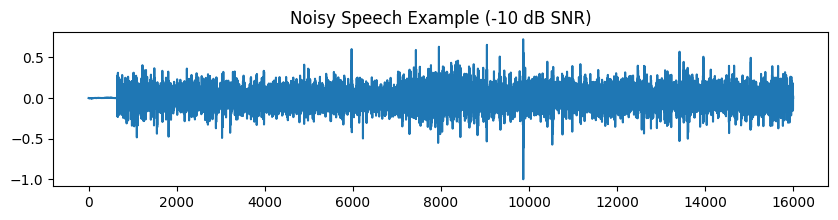

In [8]:
## Load Noise and Apply Low SNR Mixing

noise_path = os.path.join(DATA_DIR, "_background_noise_")
noise_file = random.choice(os.listdir(noise_path))

noise, _ = torchaudio.load(os.path.join(noise_path, noise_file))
noise = noise.mean(0)

def mix_snr(signal, noise, snr_db):
    if noise.numel() < signal.numel():
        repeats = int(np.ceil(signal.numel() / noise.numel()))
        noise = noise.repeat(repeats)

    noise = noise[:signal.numel()]

    signal_norm = torch.norm(signal)
    noise_norm = torch.norm(noise)

    desired_noise_norm = signal_norm / (10 ** (snr_db / 20))
    noise = noise * (desired_noise_norm / noise_norm)

    noisy_signal = signal + noise
    noisy_signal = noisy_signal / noisy_signal.abs().max()

    return noisy_signal

SNR = -10
noisy_speech = mix_snr(speech, noise, SNR)


plt.figure(figsize=(10,2))
plt.plot(noisy_speech.numpy())
plt.title("Noisy Speech Example (-10 dB SNR)")
plt.show()


In [9]:
## Construct Long Training & Validation Signals

def construct_signal(data_dir, fs, duration_sec):
    word_dirs = [
        d for d in os.listdir(data_dir)
        if os.path.isdir(os.path.join(data_dir, d))
        and not d.startswith("_")
    ]

    target_len = duration_sec * fs
    audio = []
    mask = []

    while sum(x.numel() for x in audio) < target_len:
        word = random.choice(word_dirs)
        word_path = os.path.join(data_dir, word)
        wav_file = random.choice(os.listdir(word_path))

        speech, _ = torchaudio.load(os.path.join(word_path, wav_file))
        speech = speech.mean(0)
        speech = speech / speech.abs().max()

        audio.append(speech)
        mask.append(torch.ones_like(speech))

        silence_len = random.randint(int(0.5*fs), int(2*fs))
        audio.append(torch.zeros(silence_len))
        mask.append(torch.zeros(silence_len))

    audio = torch.cat(audio)[:target_len]
    mask = torch.cat(mask)[:target_len]
    return audio, mask

audio_train, mask_train = construct_signal(DATA_DIR, fs, 600)
audio_val, mask_val     = construct_signal(DATA_DIR, fs, 120)


In [10]:
## Add Noise to Training & Validation Signals

audio_train = mix_snr(audio_train, noise, -10)
audio_val   = mix_snr(audio_val, noise, -10)


In [11]:
## Feature Extraction

mfcc = torchaudio.transforms.MFCC(
    sample_rate=fs,
    n_mfcc=13,
    melkwargs={
        "n_fft": 256,
        "hop_length": 128
    }
)

X_train = mfcc(audio_train)
X_val   = mfcc(audio_val)


mean = X_train.mean(dim=1, keepdim=True)
std  = X_train.std(dim=1, keepdim=True)

X_train = (X_train - mean) / (std + 1e-8)
X_val   = (X_val   - mean) / (std + 1e-8)


/home/hasith/Personal/vad/.venv/lib/python3.13/site-packages/torchaudio/functional/functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (129) may be set too low.
  warnings.warn(


In [12]:
## Frame-Level Label Alignment

def frame_labels(sample_mask, frame_len=256, hop_len=128):
    frames = sample_mask.unfold(0, frame_len, hop_len)
    return frames.mode(dim=1).values

y_train = frame_labels(mask_train)
y_val   = frame_labels(mask_val)


In [13]:
## Sequence Buffering

def buffer_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    hop = int(seq_len * 0.25)

    max_len = min(X.shape[1], y.shape[0])

    for i in range(0, max_len - seq_len, hop):
        x_chunk = X[:, i:i+seq_len].transpose(0, 1)
        y_chunk = y[i:i+seq_len]

        # Safety check
        if x_chunk.shape[0] == y_chunk.shape[0]:
            X_seq.append(x_chunk)
            y_seq.append(y_chunk)

    return X_seq, y_seq


In [14]:
seq_len = int(8 * fs / 128)

X_train_seq, y_train_seq = buffer_sequences(X_train, y_train, seq_len)
X_val_seq,   y_val_seq   = buffer_sequences(X_val,   y_val,   seq_len)


print("One training sequence shape:", X_train_seq[0].shape)
print("One label sequence shape:", y_train_seq[0].shape)


One training sequence shape: torch.Size([1000, 13])
One label sequence shape: torch.Size([1000])


Network Architecture

Long Short-Term Memory (LSTM) networks are well suited for sequence modelling tasks due to their
ability to learn long-term temporal dependencies. In this prototype, a Bidirectional LSTM (BiLSTM)
network is used to model both past and future context within an audio sequence, which is important
for accurate voice activity detection.

The network consists of two stacked BiLSTM layers followed by a fully connected output layer that
predicts speech and non-speech classes for each time frame.


In [15]:
class VADBiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Linear(hidden_dim * 2, 2)  # 2 classes: speech / non-speech

    def forward(self, x):
        # x: [batch, time, features]
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out


In [16]:
## Model Initialization

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VADBiLSTM(input_dim=13).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)

VADBiLSTM(
  (lstm): LSTM(13, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [17]:
## Training Setup

def to_tensor(seq_list, dtype):
    return [torch.tensor(x, dtype=dtype) for x in seq_list]


X_train_seq = to_tensor(X_train_seq, torch.float32)
y_train_seq = to_tensor(y_train_seq, torch.long)

X_val_seq   = to_tensor(X_val_seq, torch.float32)
y_val_seq   = to_tensor(y_val_seq, torch.long)



/tmp/ipykernel_410697/1606703382.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return [torch.tensor(x, dtype=dtype) for x in seq_list]


Model Training

The model is trained using the Adam optimiser and cross-entropy loss.
Training is performed on overlapping 8-second audio sequences.
The loss is computed at the frame level to enable fine-grained voice activity detection.


In [18]:
## Training Loop

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for X_seq, y_seq in zip(X_train_seq, y_train_seq):
        X_seq = X_seq.unsqueeze(0).to(device)      # [1, time, features]
        y_seq = y_seq.unsqueeze(0).to(device)      # [1, time]

        optimizer.zero_grad()

        outputs = model(X_seq)

        T = min(outputs.shape[1], y_seq.shape[1])
        outputs = outputs[:, :T, :]
        y_seq = y_seq[:, :T]

        loss = criterion(
            outputs.reshape(-1, 2),
            y_seq.reshape(-1)
        )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(X_train_seq)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {avg_loss:.4f}")


Epoch [1/10] - Training Loss: 0.4637
Epoch [2/10] - Training Loss: 0.3600
Epoch [3/10] - Training Loss: 0.3404
Epoch [4/10] - Training Loss: 0.3291
Epoch [5/10] - Training Loss: 0.3156
Epoch [6/10] - Training Loss: 0.3039
Epoch [7/10] - Training Loss: 0.2959
Epoch [8/10] - Training Loss: 0.2955
Epoch [9/10] - Training Loss: 0.3134
Epoch [10/10] - Training Loss: 0.2920


Validation

After training, the model is evaluated on unseen validation data.
Predictions are generated at the frame level and compared against the
ground truth labels.

In [19]:
## Inference

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_seq, y_seq in zip(X_val_seq, y_val_seq):
        X_seq = X_seq.unsqueeze(0).to(device)

        outputs = model(X_seq)

        T = min(outputs.shape[1], y_seq.shape[0])
        outputs = outputs[:, :T, :]
        y_seq = y_seq[:T]

        preds = torch.argmax(outputs, dim=-1).cpu().view(-1)

        all_preds.append(preds)
        all_targets.append(y_seq.view(-1))

all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)



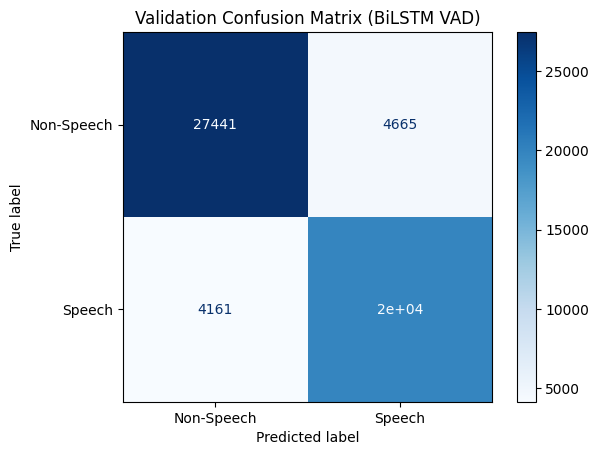

In [20]:
## Confusion Matrix 

cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Non-Speech", "Speech"]
)

disp.plot(cmap="Blues")
plt.title("Validation Confusion Matrix (BiLSTM VAD)")
plt.show()


In [21]:
## Evaluation Matrics 

TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

accuracy  = (TP + TN) / cm.sum()
precision = TP / (TP + FP + 1e-8)
recall    = TP / (TP + FN + 1e-8)
f1        = 2 * precision * recall / (precision + recall + 1e-8)

print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1 Score : {f1:.3f}")


Accuracy : 0.842
Precision: 0.809
Recall   : 0.826
F1 Score : 0.817


Part D - Software Testing and Evaluation

In [22]:
## TODO

Part E - Equity, Diversity, Inclusion (EDI) and Sustainability

In [23]:
## TODO